In [1]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li
from skimage.transform import rescale


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


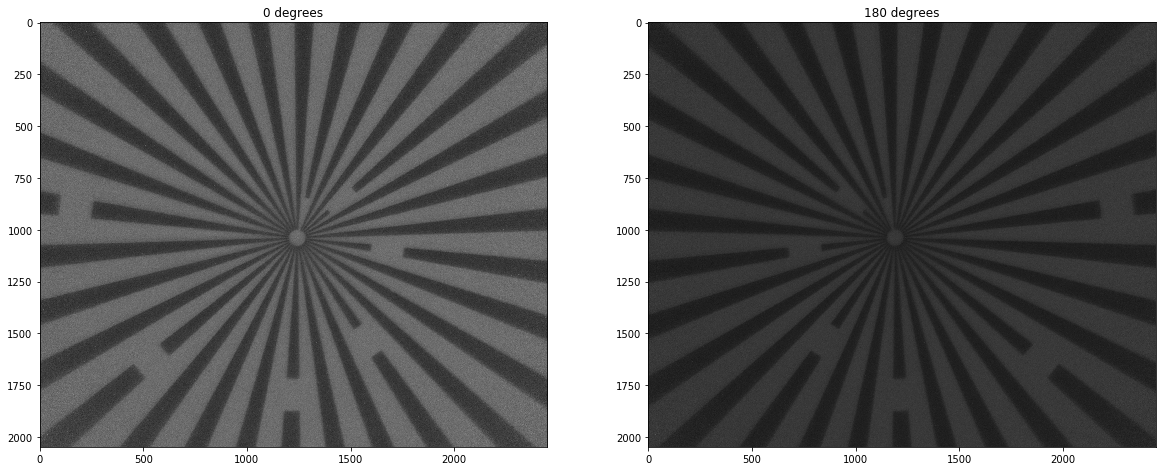

In [2]:
samples = ['./samples/rot_0.tif', 
           './samples/rot_180.tif',
           './samples/faked_rot_0_titled_5.3deg.tif',
           './samples/faked_rot_180.tif']

img0 = tiff.imread(samples[0])
img180 = tiff.imread(samples[1])

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0, cmap='gray')
plt.title("0 degrees")
plt.subplot(122)
plt.imshow(img180, cmap='gray')
plt.title("180 degrees")
plt.show()


### Rescale image to speed up processing. Rescale to only 40% of the size. 

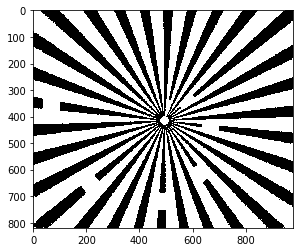

In [3]:
img0_rescaled = rescale(img0, 0.4, mode='reflect')
thresh = threshold_li(img0_rescaled)
binary = img0_rescaled > thresh

plt.imshow(binary, cmap='gray')
plt.show()

In [4]:
# Create few empty image for processing. 

img0_empty = np.zeros_like(binary, dtype=np.uint8)
img0_binary = np.zeros_like(binary, dtype=np.uint8)
img0_binary_inv = np.zeros_like(binary, dtype=np.uint8)

img0_binary[binary] = 255
img0_binary_inv[~binary] = 255

## Inverse Image Mask


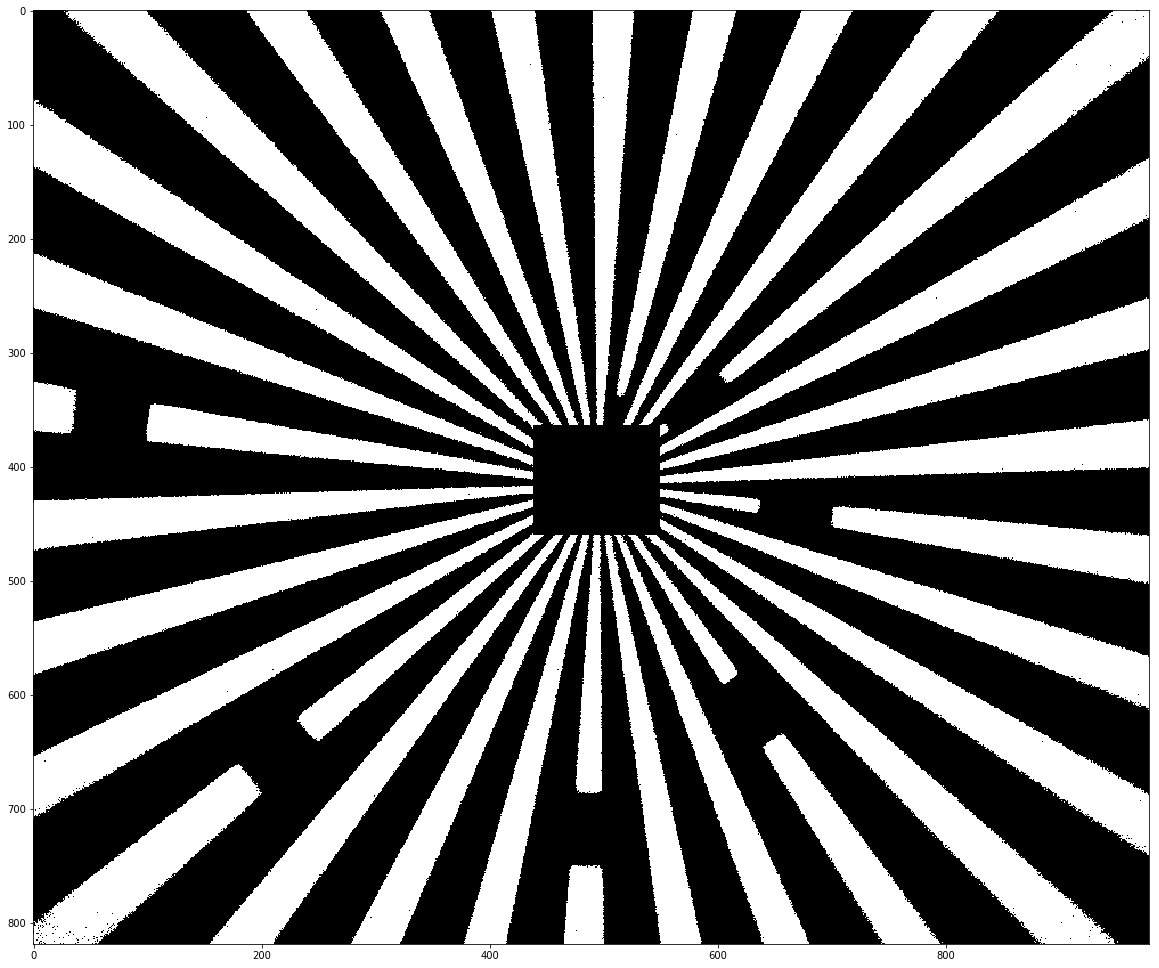

In [5]:
# Mask out center of image. 
h, w = img0_binary.shape
img0inv_masked = img0_binary_inv.copy()
mask = np.zeros_like(img0_binary, dtype=np.uint8)

vertices = np.array([[
                (w/2 - 50, h/2 - 45),
                (w/2 + 60, h/2 - 45), 
                (w/2 + 60, h/2 + 50), 
                (w/2 - 50, h/2 + 50)
            ]], 
                        dtype=np.int32)

cv2.fillPoly(mask, vertices, 255)
masked = cv2.bitwise_and(img0inv_masked, mask)
img0inv_masked[masked > 0] = 0

plt.figure(figsize=(20, 20))
plt.imshow(img0inv_masked, cmap='gray')
plt.show()



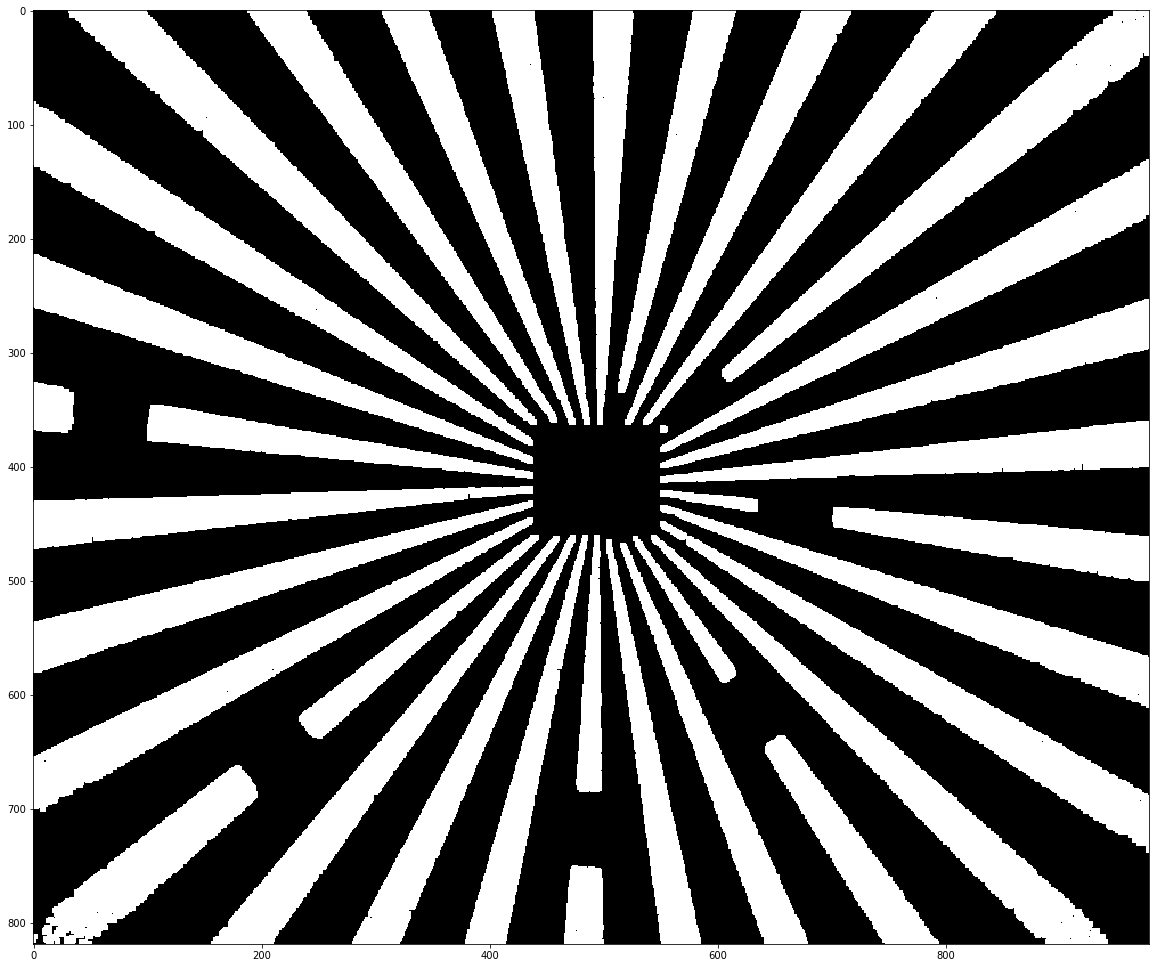

In [107]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(img0inv_masked,cv2.MORPH_OPEN, kernel, iterations = 2)

plt.figure(figsize=(20, 20))
plt.imshow(opening, cmap='gray')
plt.show()


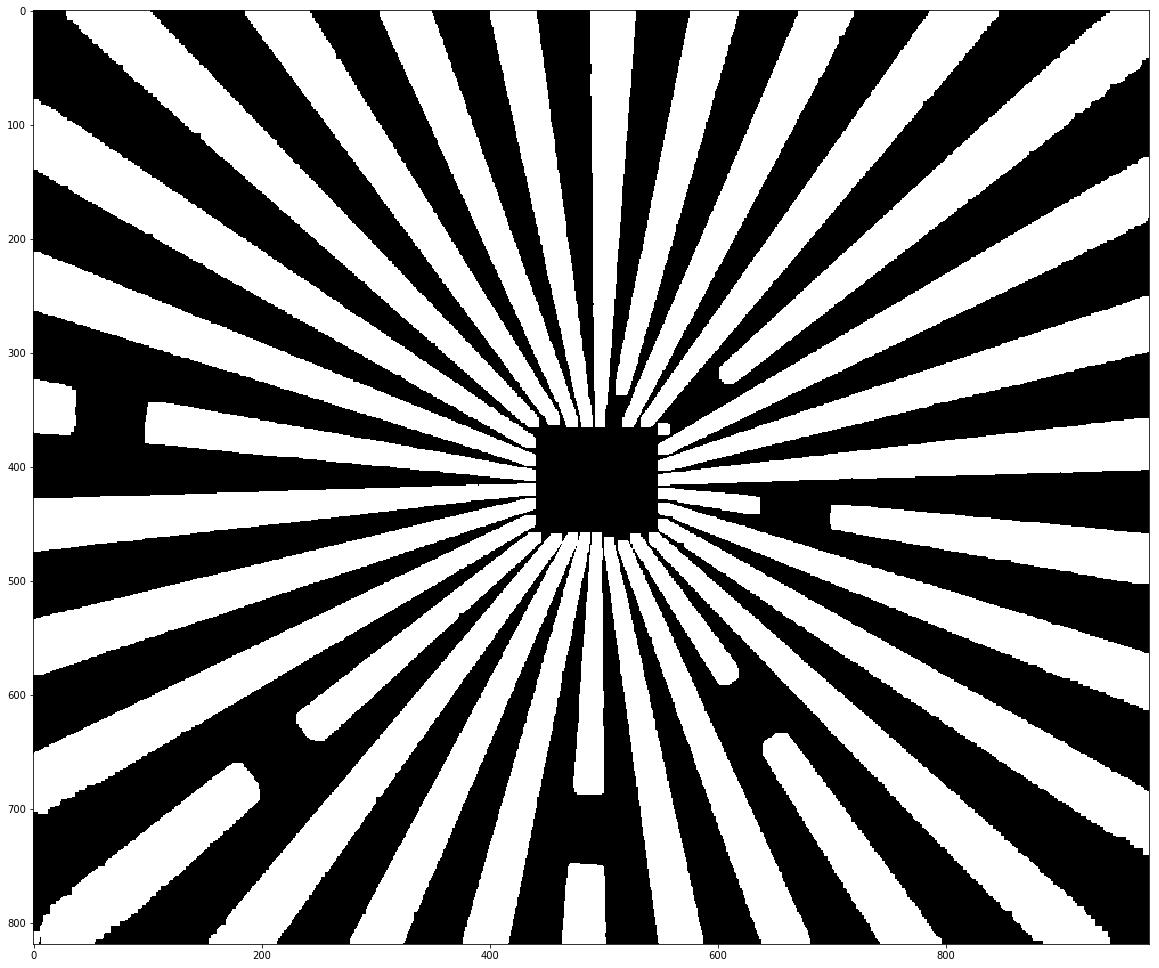

In [109]:
fg = cv2.dilate(opening,kernel,iterations=2)
plt.figure(figsize=(20, 20))
plt.imshow(fg, cmap='gray')
plt.show()

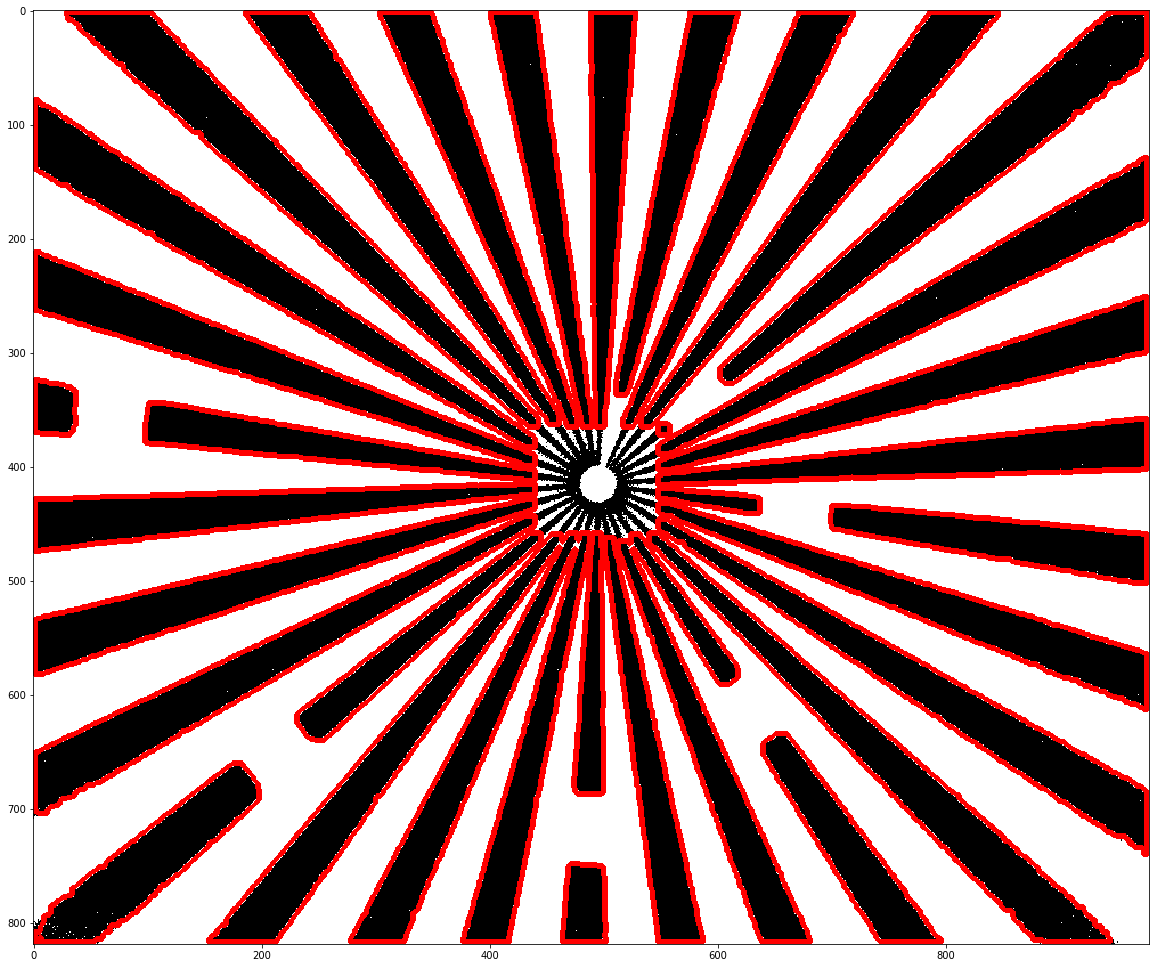

In [110]:
result = np.dstack((img0_binary, img0_binary, img0_binary))

im2, cnts, hierarchy = cv2.findContours(fg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE )
cv2.drawContours(result, cnts, -1, (255, 0, 0), 3)

plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show()

489.5 409.5


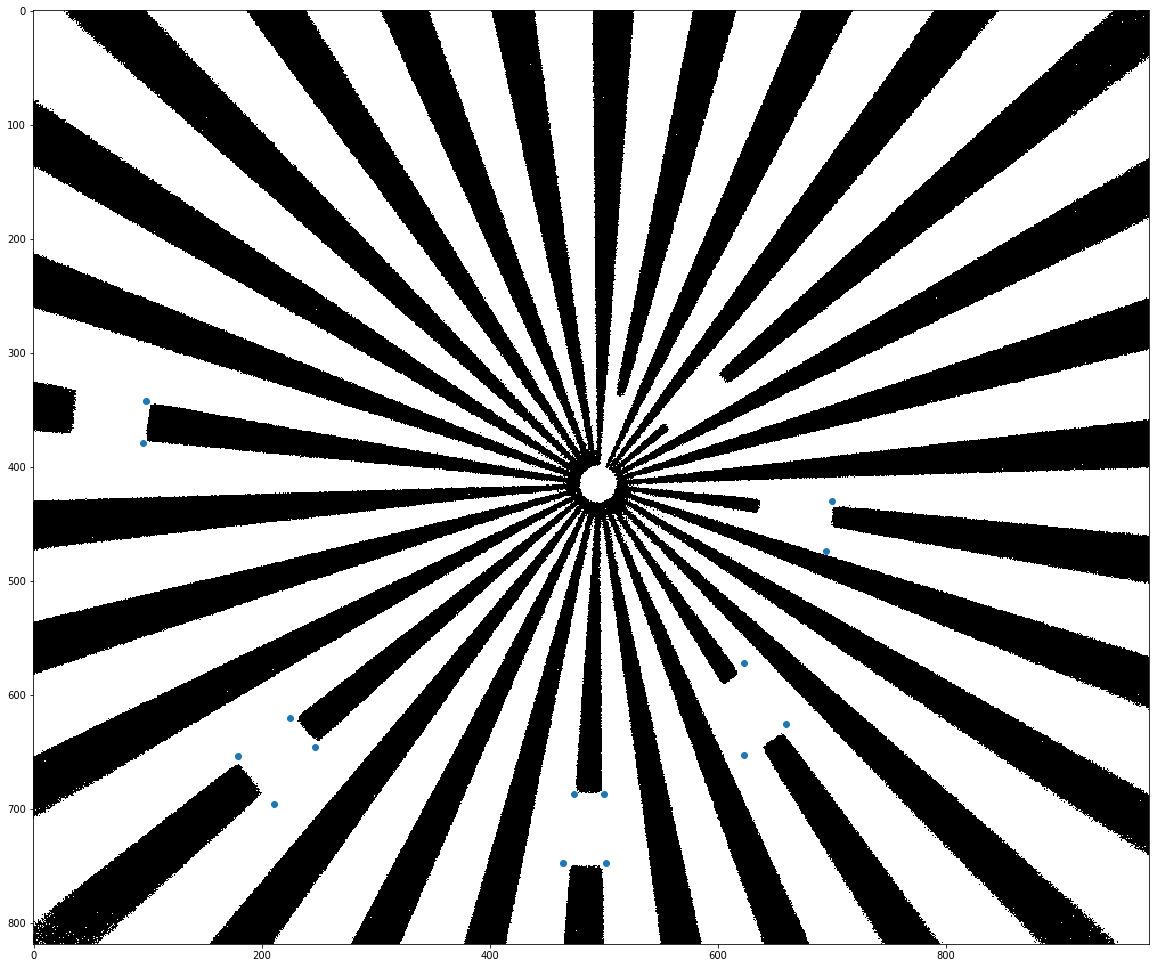

In [111]:
result = np.dstack((img0_binary, img0_binary, img0_binary))

X = []
Y = []

rows, cols = img0_binary.shape
centerX = cols/2
centerY = rows/2

print (centerX, centerY)

#cnt = cnts[10]
#if 1:
for cnt in cnts:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    for pt in box:
        dist = np.sqrt((centerX - pt[0])** 2 + (centerY - pt[1])**2)
        if (dist > 170 and dist < 400):
            X.append(pt[0])
            Y.append(pt[1])
    
X_filtered = X
Y_filtered = Y

# for i in range(len(X)):
#     if X[i] > 30 and X[i] < 900 and Y[i] > 30 and Y[i] < 700:
#         if X[i] < (centerX - 100) and X[i] > (centerX + 100):
#             X_filtered.append(X[i])
#             Y_filtered.append(Y[i])
    

plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.scatter(X_filtered, Y_filtered)
plt.show()